# 3. Análise Exploratória de Dados (EDA) 
📒 `3.0-rc-eda.ipynb`

**Objetivo:** Explorar os dados para identificar padrões, tendências, relações entre variáveis e potenciais problemas que possam impactar a modelagem.

In [1]:
# Carrega Bibliotecas
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega Bibliotecas Auxiliares
import sys
import os
import warnings

# Testes Estatísticos
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Carrega Funções Auxiliares
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import plot_distribution_and_boxplot, plot_pareto, plot_boxplots_category, plot_correlation_matrix, cramers_v

# Configura o matplotlib para mostrar gráficos inline
%matplotlib inline

# Setup para mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Desabilita mensagens de FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Carrega dados

In [2]:
# Carrega dados
df = pd.read_csv("../data/processed/data_cleaned.csv")

# Informações sobre as colunas
print("N° de linhas e colunas: ", df.shape)

# Visualiza os dados
df.head()

N° de linhas e colunas:  (33180, 13)


,tipo,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,tipo_falha,Desgaste da Ferramenta(FDF),Dissipacao de Calor(FDC),Falha de Potencia(FP),Tensao Excessiva(FTE),Falha Aleatoria(FA)
0,Baixa,298.3,309.1,1616.0,31.1,195.0,0,Sem falhas,0,0,0,0,0
1,Baixa,298.2,308.4,1388.0,53.8,137.0,0,Sem falhas,0,0,0,0,0
2,Baixa,298.2,307.8,1528.0,31.1,94.0,0,Sem falhas,0,0,0,0,0
3,Media,300.9,310.8,1599.0,33.0,7.0,0,Sem falhas,0,0,0,0,0
4,Baixa,299.6,310.5,1571.0,33.9,94.0,0,Sem falhas,0,0,0,0,0


## 1. Variáveis Categóricas

**Insights Esperados:**

**Variáveis alvos:**
- `falha_maquina`: Tipos de falhas classificadas
- `tipo_falha`: Variável binária indicando se houve falha geral na máquina (1) ou não (0).
- `tipo`: Tipo de produto/máquina, definido por categoria de carga: **L** (Baixa), **M** (Média), **H** (Alta). 

### Estatistica Descritiva 

In [3]:
df.describe(include=['object'])

,tipo,tipo_falha
count,33180,33180
unique,3,6
top,Baixa,Sem falhas
freq,22511,32674


### i) Variável Alvo (falha_maquina) - Binário

#### Distribuição de Frequência das Classes

Variável Alvo Desbalanceada, classe=1 (falha) abaixo de 10%


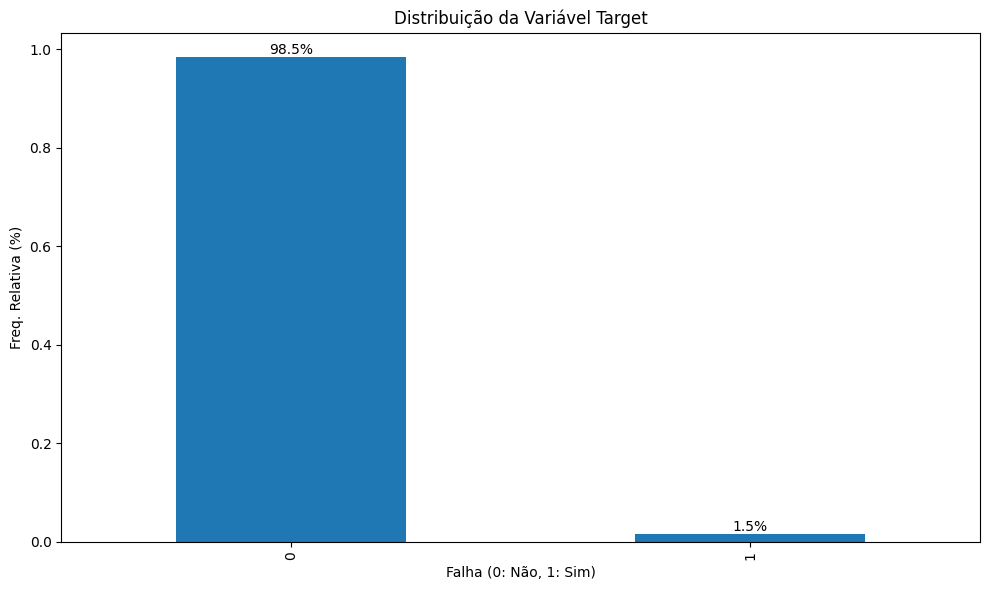

In [4]:
# Distribuição da Variável Target
plt.figure(figsize=(10, 6))
ax = df['falha_maquina'].value_counts(normalize=True).plot(kind='bar', title='Distribuição da Variável Target')

# Adiciona rótulos nas barras
for i, v in enumerate(df['falha_maquina'].value_counts(normalize=True)):
    ax.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.xlabel('Falha (0: Não, 1: Sim)')
plt.ylabel('Freq. Relativa (%)')

if df['falha_maquina'].value_counts(normalize=True)[1] < 0.1:
    print("Variável Alvo Desbalanceada, classe=1 (falha) abaixo de 10%")
else:
    print("Variável Alvo Não Desbalanceada")

plt.tight_layout()

# Salvar o gráfico
plt.savefig('../reports/figures/3_eda_barplot_target')

**Insights:**
- **Classe Binária `falha_maquina` Desbalanceada**
    - A variável alvo esta altamente desbalanceada, havendo poucos registros de falhas (<2%) da classe=1, o que acaba sendo um desafio na manutenção preditiva, por haver poucos dados de falhas.

### ii) Tipo de Falha (tipo_falha) - Multiclasses

In [5]:
# Distribuição das classes da variável 'tipo_falha'
df['tipo_falha'].value_counts(normalize=True) *100

tipo_falha
Sem falhas                     98.474985
Dissipacao de Calor(FDC)        0.635925
Tensao Excessiva(FTE)           0.421941
Falha Aleatoria(FA)             0.201929
Desgaste da Ferramenta(FDF)     0.177818
Falha de Potencia(FP)           0.087402
Name: proportion, dtype: float64

**Insights:**
- **Multiclasses `tipo_falha` desbalanceadas**
    - A distribuição das classes de falhas estão desbalanceadas que pode impactar negativamente no desempenho do modelo. Precisaremos aplicar algumas estratégias, primeiro de balanceamento e segundo o fato de ter um problema de multiclasses.

#### Analisando Somente Dados de Falhas

- Criado um novo dataframe com subset sem falhas `df_falhas`
- Pareto de Falhas por Tipo de Falha

N° de registros com falha:  436


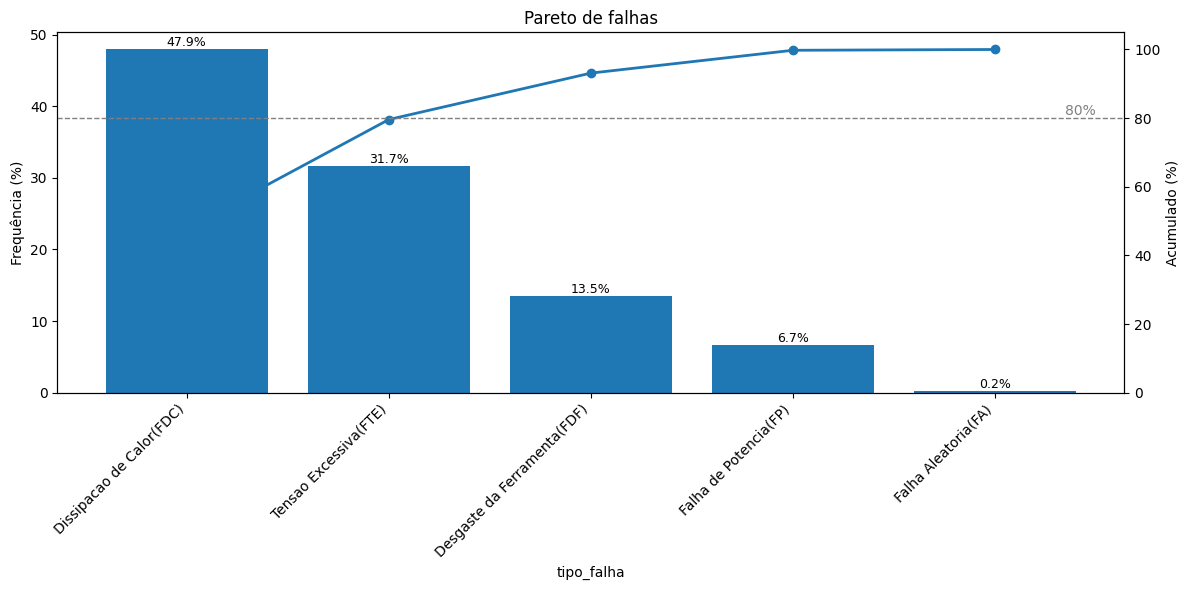

<Figure size 640x480 with 0 Axes>

In [6]:
# Cria a condição de inconsistência
dados_sem_falha = (df['falha_maquina'] == 1) & (df['tipo_falha'] != 'Sem falhas')

# Remove do dataframe original
df_falhas = df[dados_sem_falha].copy()

# N° de registros com falha
print("N° de registros com falha: ", df_falhas.shape[0])

# Distribuição das classes da variável 'tipo_falha'
df_falhas['tipo_falha'].value_counts(normalize=True) *100


# Plotar o gráfico de Pareto
plot_pareto(df_falhas, col='tipo_falha', normalize=True, cutoff=0.80, rotate_xticks=45, title='Pareto de falhas')

# Salvar o gráfico
plt.savefig('../reports/figures/3_eda_pareto_tipo_falha')

**Inisghts:**
- Com base no gráfico de pareto das classificações de falhas, será priorizado o TOP#4 Falhas que correspondem ao total de 98.2% do totaldas falhas:
    - Dissipacao de Calor(FDC) = 47.8%
    - Tensao Excessiva(FTE) = 31.6%
    - Desgaste de Ferramenta(FDF) = 13.5%
    - Falha de Potencia(FP) = 6.9%

- Não temos uma quantidade significativa da classe `Falha Aleatoria(FA)` representando 0.2%, desta forma, **aplicaremos um teste estatístico de proporções para avaliarmos sua significância no modelo**;
- Selecionaremos as variáveis mais relevantes para que não venhamos prejudicar o modelo devido a um grande desequilíbrio de classes. Como o objetivo é classificar o tipo de falha e aplicar os conceitos de ciência de dados, será removido.

### iii) Tipo de Máquina - IP (tipo)

##### Distribuição de Frequência(%)

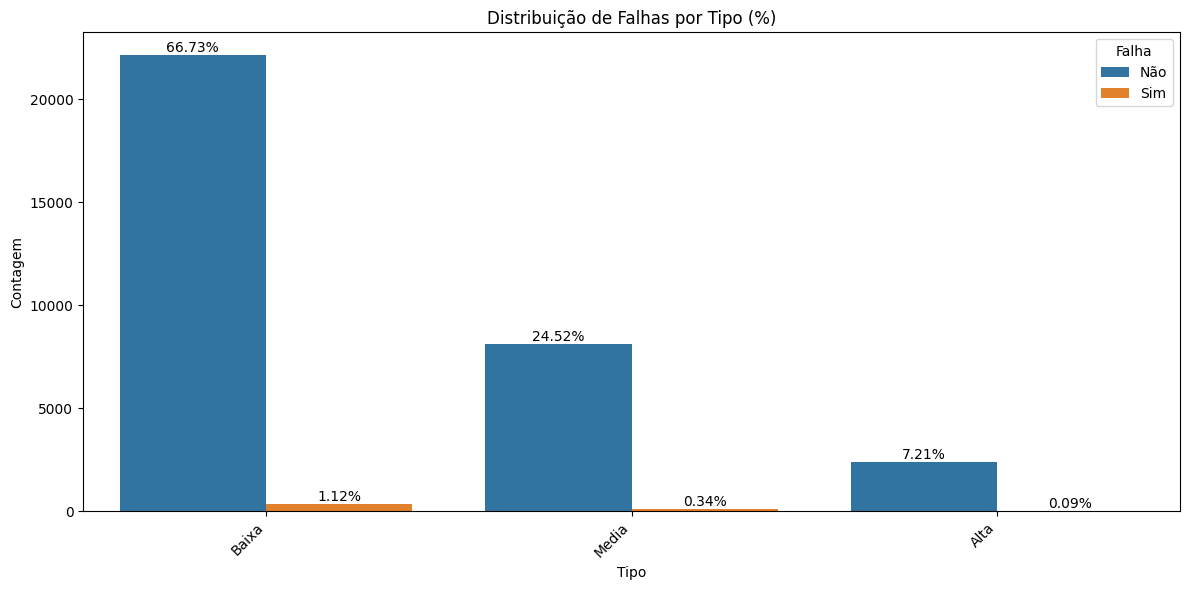

In [7]:
# Criar um gráfico para a distribuição de falhas por tipo
plt.figure(figsize=(12, 6))

# Criar o gráfico de barras
ax = sns.countplot(x='tipo', data=df, hue='falha_maquina', 
                  order=df['tipo'].value_counts().index)

# Calcular percentuais para cada grupo
total = len(df)
for container in ax.containers:
    percentages = [count/total*100 for count in container.datavalues]
    # Adiciona os percentuais em cada barra
    ax.bar_label(container, labels=[f'{p:.2f}%' for p in percentages], label_type='edge')

# Configurar a legenda
plt.legend(title='Falha', labels=['Não', 'Sim'])

# Configurar os rótulos dos eixos
plt.ylabel('Contagem')
plt.xlabel('Tipo')
plt.title('Distribuição de Falhas por Tipo (%)')

# Ajustar o layout
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

# Salvar o gráfico
plt.savefig('../reports/figures/3_eda_barplot_tipo_hue_tipo_falha', 
            bbox_inches='tight', 
            dpi=300)

In [8]:
# Groupy by tipo and tipo_falha
df_falhas_tipo = df.groupby('tipo')['falha_maquina'].value_counts().reset_index()
df_falhas_tipo['(%)'] = round(df_falhas_tipo['count'] / df_falhas_tipo['count'].sum() * 100, 2)
df_falhas_tipo.sort_values(by='(%)', ascending=False, inplace=True)
df_falhas_tipo

,tipo,falha_maquina,count,(%)
2,Baixa,0,22140,66.73
4,Media,0,8135,24.52
0,Alta,0,2391,7.21
3,Baixa,1,371,1.12
5,Media,1,112,0.34
1,Alta,1,31,0.09


**Insights:**
- A **classe “Baixa” é a classe majoritária(66.88%)** enquanto a **“Alta” é a classe minoritária (7.22%).**
- O **acumulado das classes "Baixa e "Média" representam 91.47% do total.**
- Extratificando por `falha_maquina` se falhou ou não, vemos que os **casos que falharam no Tipo Alta, corresponderam ao total de  7.28% do total**, enquanto **analisando somente os dados que falharam "Falha=Sim" do tipo "Alta" representam  < 1% do total, tendo baixa representatividade.** 

### iv) Matriz Headmap de Associação Categóricas ( Cramér's V)

**Objetivo:**
- Verificar as associações entre as variavéis categóricas

In [9]:
# Gerar variáveis dummy sem remover a coluna original
dummies = pd.get_dummies(df['tipo'], prefix='tipo', drop_first=False)

# Concatenar as dummies ao DataFrame original
df = pd.concat([df, dummies], axis=1)

# Substituir valores True/False por Númericos 0 ou 1
df['tipo_Alta'] = df['tipo_Alta'].astype(int)
df['tipo_Baixa'] = df['tipo_Baixa'].astype(int)
df['tipo_Media'] = df['tipo_Media'].astype(int)

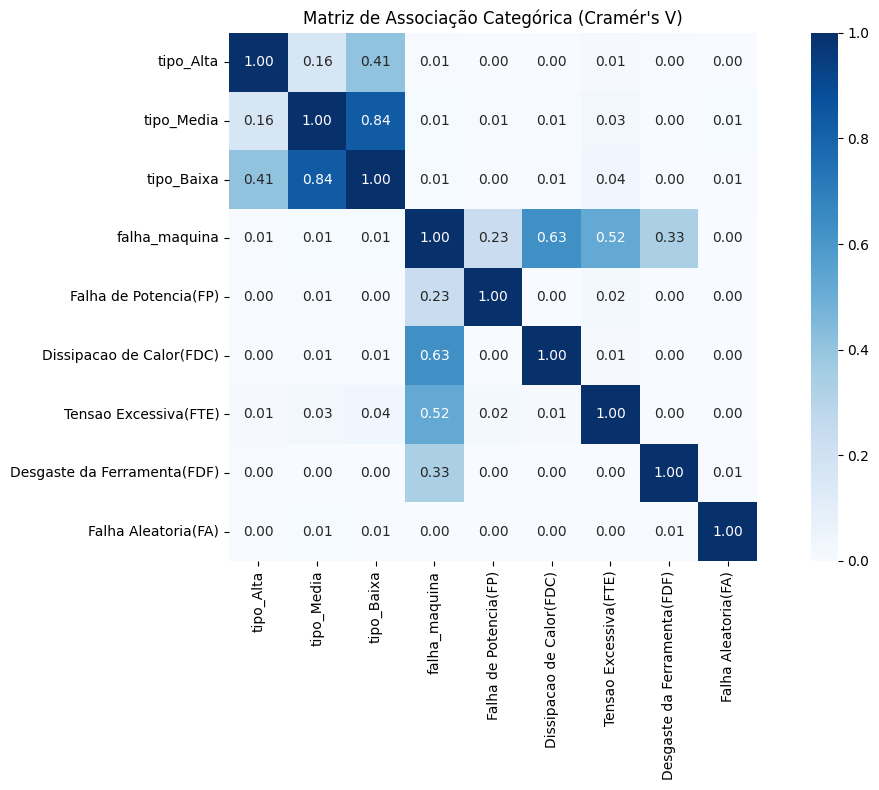

<Figure size 640x480 with 0 Axes>

In [10]:
#### Teste de Associação Categóricas ( Cramér's V)

# Variáveis categóricas
categorical_vars = [ 
    'tipo_Alta', 
    'tipo_Media', 
    'tipo_Baixa', 
    'falha_maquina', 
    'Falha de Potencia(FP)', 
    'Dissipacao de Calor(FDC)', 
    'Tensao Excessiva(FTE)', 
    'Desgaste da Ferramenta(FDF)', 
    'Falha Aleatoria(FA)'
    ]

# Matriz de associação
assoc_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for i in categorical_vars:
    for j in categorical_vars:
        if i == j:
            assoc_matrix.loc[i, j] = 1.0
        else:
            confusion = pd.crosstab(df[i], df[j])
            assoc_matrix.loc[i, j] = cramers_v(confusion)

assoc_matrix = assoc_matrix.astype(float)

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(assoc_matrix, annot=True, cmap="Blues", fmt=".2f", square=True)
plt.title("Matriz de Associação Categórica (Cramér's V)")
plt.tight_layout()
plt.show()

plt.savefig('../reports/figures/3_eda_assoc_matrix', bbox_inches='tight', dpi=300)

**Insights:**
- Associações Fortes entre Tipos de Máquina: `tipo_Baixa` vs `tipo_Média`, V= 0.84;
- Nenhuma associação relevante entre tipo de máquina e falhas.
- Melhor associação entre tipo de máquina =`tipo_Baixa` vs `FTE` (Falha Tensão Excessiva) V= 0.04;
- A variável `falha_maquina` mostra correlação moderada com os tipos de falha, justamente as Top#4 que definimos anteriormente, removendo falhas aleatórias(FA).
    - FDC (Dissipação de Calor): 0.68
    - FTE (Tensão Excessiva): 0.57
    - FP (Falha de Potência): 0.25
    - FDF (Desgaste da Ferramenta): 0.36

- Essas associações comprovam a remoção da variável "Falhas Aleatórias" no gráfico de paretos de falhas, selecionando Top#4

### v) Testes Estatísticos - Variáveis Categóricas

### a) O tipo de máquina "Baixa" influencia a ocorrência de falhas de máquina?
    - H0: Tipo da máquina Baixa e falha FTE são independentes
    - H1: Existe associação entre tipo da máquina Baixa e FTE
    - Teste: Qui-Quadrado

In [11]:
# Teste de Associação Categóricas ( Cramér's V)
contingencia_fdf = pd.crosstab(df['tipo_Baixa'], df['falha_maquina'])
chi2, p, _, _ = chi2_contingency(contingencia_fdf)

print(f"Valor do Qui-quadrado: {chi2:.2f}")
print(f"Valor-p: {p:.4f}")

if p < 0.05:
    print("Rejeitamos H0: Existe associação entre tipo de máquina Baixa e ocorrência de Falhas.")
else:
    print("Não rejeitamos H0: Não há associação significativa entre tipo de máquina Baixa e Falha de Máquina.")


Valor do Qui-quadrado: 4.30
Valor-p: 0.0382
Rejeitamos H0: Existe associação entre tipo de máquina Baixa e ocorrência de Falhas.


**Insights:**
- Teste 01: Existe associação estatisticamente significativa entre a máquina de tipo Baixa e a ocorrência de falhas por Tensão Excessiva (FTE).

---

## 2. Variáveis Númericas

**Insights Esperados:**

**Variáveis:**
- `temperatura_ar`:
- `temperatura_processo`:
- `umidade_relativa`:
- `velocidade_rotacional`:
- `torque`:
- `desgaste_da_ferramenta`:

### i) Estatistica Descritiva

In [12]:
# Estatística Descritiva das variáveis numéricas dos sensores
df.describe(include=['float64'])

,temperatura_ar,temperatura_processo,velocidade_rotacional,torque,desgaste_da_ferramenta
count,33180.000000,33180.000000,33180.000000,33180.000000,33180.000000
mean,299.859879,309.941365,1499.723508,40.983198,103.790989
std,1.786508,1.330597,98.479976,7.730227,59.890011
min,295.500000,305.900000,1236.000000,17.300000,0.000000
25%,298.500000,308.900000,1435.000000,35.600000,58.000000
50%,299.600000,309.800000,1483.000000,40.600000,94.000000
75%,301.000000,310.800000,1556.000000,46.300000,154.000000
max,304.500000,313.800000,1772.000000,63.200000,253.000000


### ii) Verificando Distribuições 

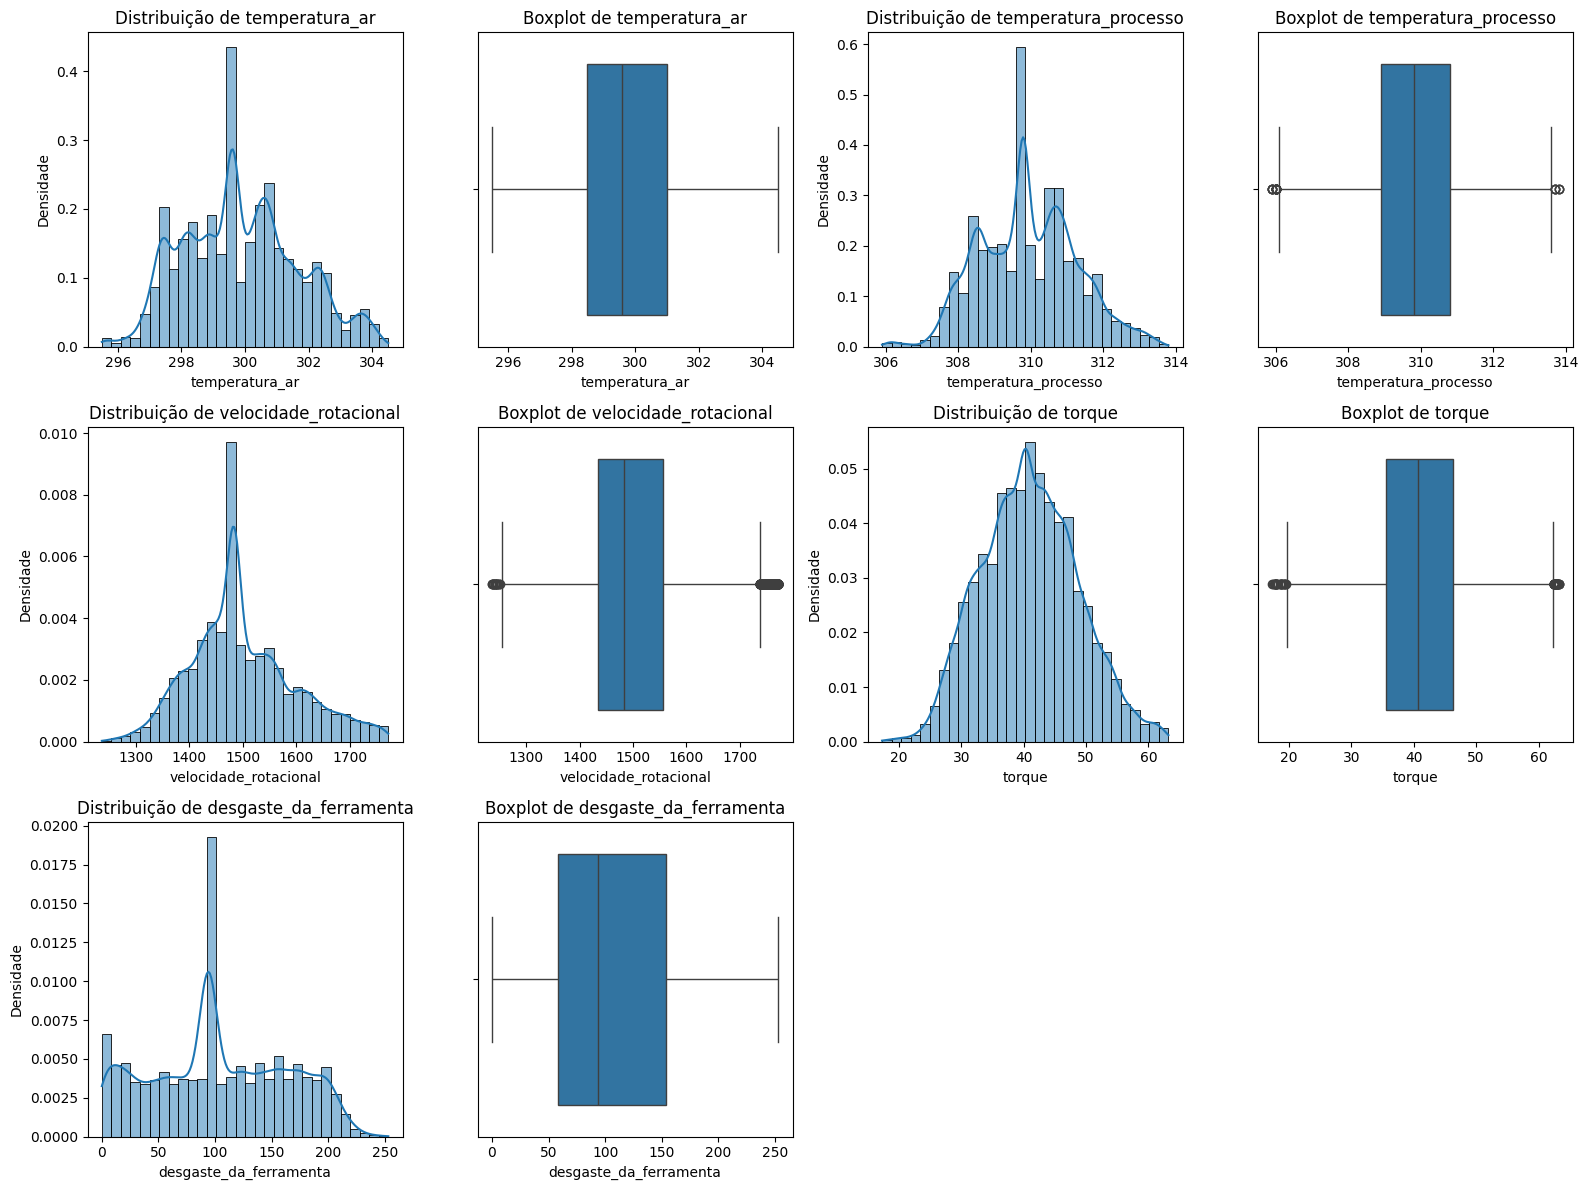

<Figure size 640x480 with 0 Axes>

In [13]:
# Declarando as colunas alvo
target_cols = [
    'falha_maquina', 
    'Falha de Potencia(FP)', 
    'Dissipacao de Calor(FDC)', 
    'Tensao Excessiva(FTE)', 
    'Desgaste da Ferramenta(FDF)', 
    'Falha Aleatoria(FA)']

# Obter todas as colunas numéricas
all_numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remover as colunas alvo que existem nas colunas numéricas
numeric_cols = [col for col in all_numeric_cols if col not in target_cols]

# Plotar a distribuição e o boxplot das variáveis numéricas
plot_distribution_and_boxplot(df, numeric_cols)

# Salvar o gráfico com melhor qualidade
plt.savefig('../reports/figures/3_eda_distribution_and_boxplot', 
            bbox_inches='tight', 
            dpi=300)


**Insights:**
- As variáveis `temperatura_ar`, `temperatura_processo`, `velocidade_rotacional` e `torque` são semelhantes á uma distribuição normal.
- Observando os gráficos de boxplot, é possível verificar a presença de outliers mesmo após a limpeza dos dados.  Esses valores serão mantidas para ser entendido as variações.
- A maior concentração de outliers em `torque` e `velocidade_rotacional` não deve ser vista como ruído, mas como parte da complexidade e variabilidade natural do processo de usinagem CNC.
- Esses outliers carregam informações críticas sobre a saúde da máquina e seu desempenho, e devem ser analisados com critério, desta forma, serão mantidos.

### iii) Matriz Headmap de Correlação Numérica

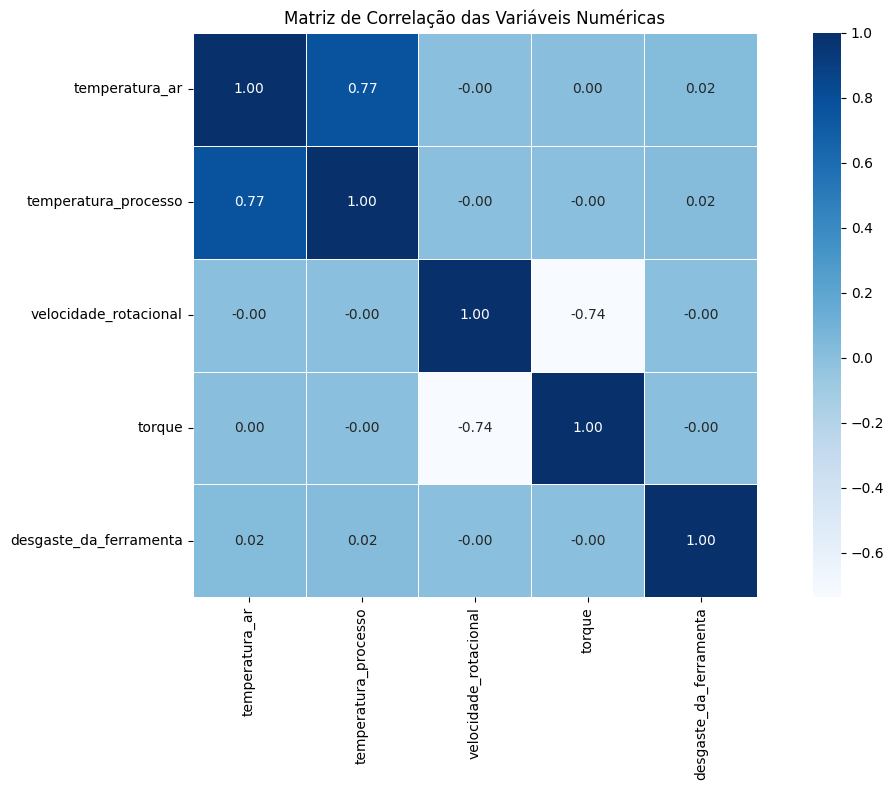

In [14]:
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Remover colunas binárias de falha
cols_to_drop = [
    'tipo_Alta', 
    'tipo_Baixa', 
    'tipo_Media',
    'Desgaste da Ferramenta(FDF)', 
    'Dissipacao de Calor(FDC)', 
    'Falha de Potencia(FP)', 
    'Tensao Excessiva(FTE)', 
    'Falha Aleatoria(FA)', 
    'falha_maquina']

numeric_cols = [col for col in numeric_cols if col not in cols_to_drop]

# Calcular a matriz de correlação
corr_df = df[numeric_cols].corr()

# Criar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, 
            annot=True,           # Mostrar os valores
            cmap='Blues',         # Esquema de cores
            fmt='.2f',           # Formato dos números
            linewidths=0.5,      # Largura das linhas
            square=True)         # Células quadradas

plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()              # Ajustar layout

# Salvar o gráfico
plt.savefig('../reports/figures/3_eda_heatmap_correlation', bbox_inches='tight', dpi=300)

# Mostrar o gráfico
plt.show()

**Insights:**
- `temperatura_ar` vs `temperatura_processo` ≈ 0,77 (FORTE+)
    -   **Correlação Forte Positiva:** Alta correlação positiva sugere que **a temperatura ambiente influencia significativamente a temperatura do processo.**
    -   Em ambientes mais quentes, o sistema pode operar em temperatura de processo naturalmente mais alta, o que **pode interferir na dissipação de calor e levar a falhas térmicas (FDC).**
- `velocidade_rotacional` vs `torque` ≈ −0,74 (FORTE-):
    - **Correlação negativa forte** — comportamento físico esperado: **quanto maior a rotação, menor o torque necessário.**
    - Essa relação pode ser usada para detectar regimes de operação fora do padrão ou anomalias em carga mecânica.

- `temperatura_ar` vs `desgaste_da_ferramenta` ρ ≈ 0.03 ( MUITO FRACA + )
    - **Leve correlação positiva**, mas pode indicar que **valores mais altos de temperatura estão relacionados com maior desgaste de ferramentas. 


**Conclusão:** A forte correlação entre as variáveis de temperatura  e velocidade vs torque indica que há indícios de multicolinearidade, sendo recomendado confirmar com a técnica VIF (Variance Inflaction Factor). Esta multicolinearidade pode impactar negativamente no modelo.

### iv) Relação Linear entre as variáveis correlacionadas

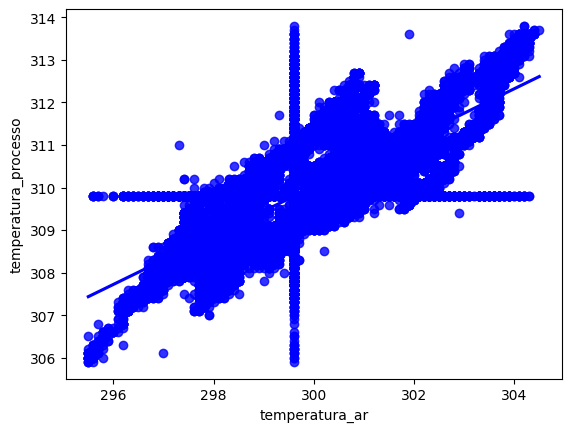

In [15]:
# Gráfico de Regressão: temperatura_ar vs temperatura_processo
sns.regplot(x='temperatura_ar', y='temperatura_processo', data=df, color='blue')
plt.savefig('../reports/figures/3_eda_regplot_temperatura_ar')

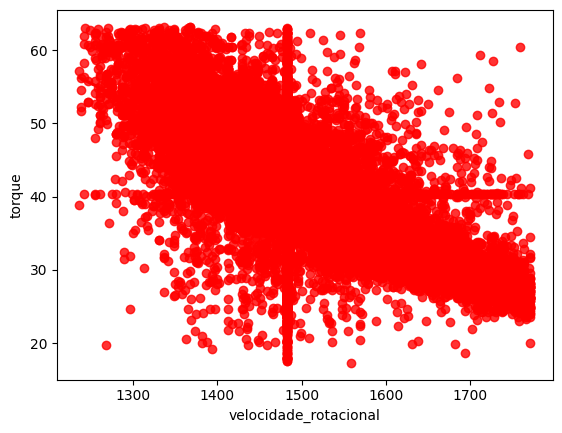

In [16]:
# Gráfico de Regressão: velocidade_rotacional vs torque
sns.regplot(x='velocidade_rotacional', y='torque', data=df, color='red')
plt.savefig('../reports/figures/3_eda_regplot_velocidade_rotacional_falhas')

### iv) Análise Bivariada

**Objetivo:**
- Verificar as variáveis númericas por falha 

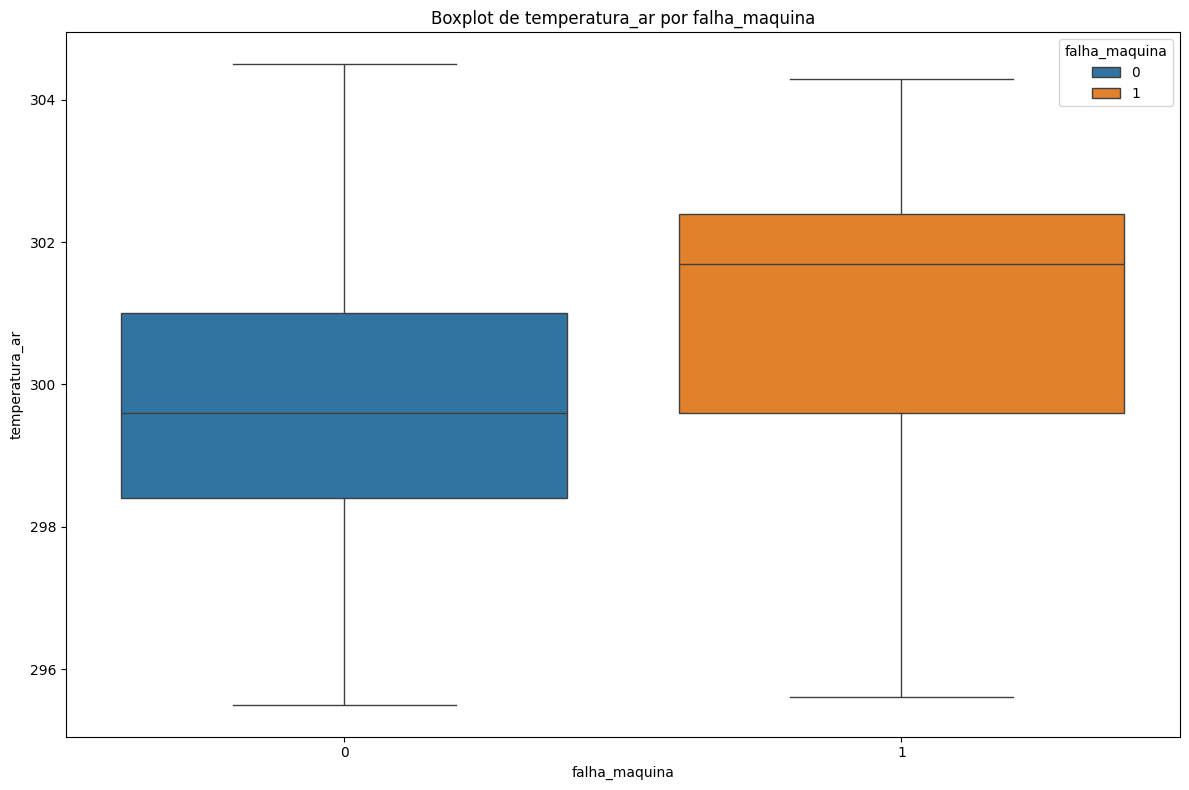

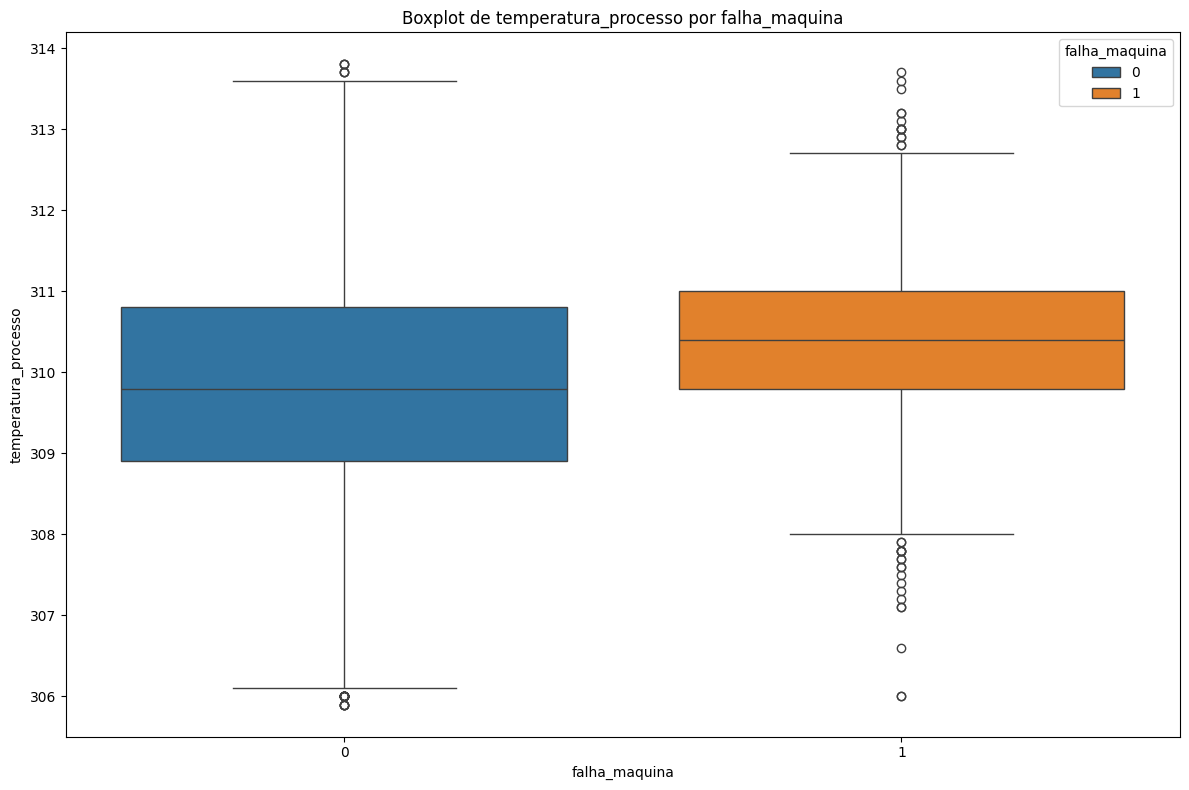

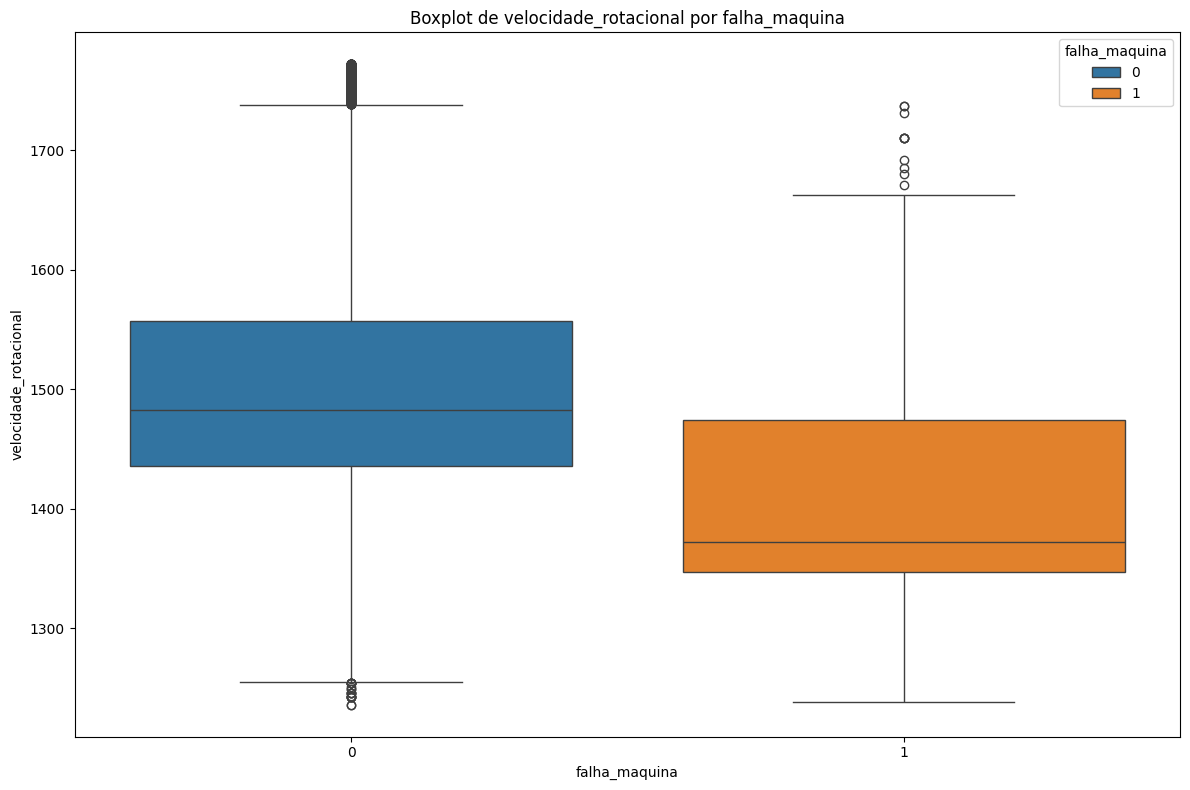

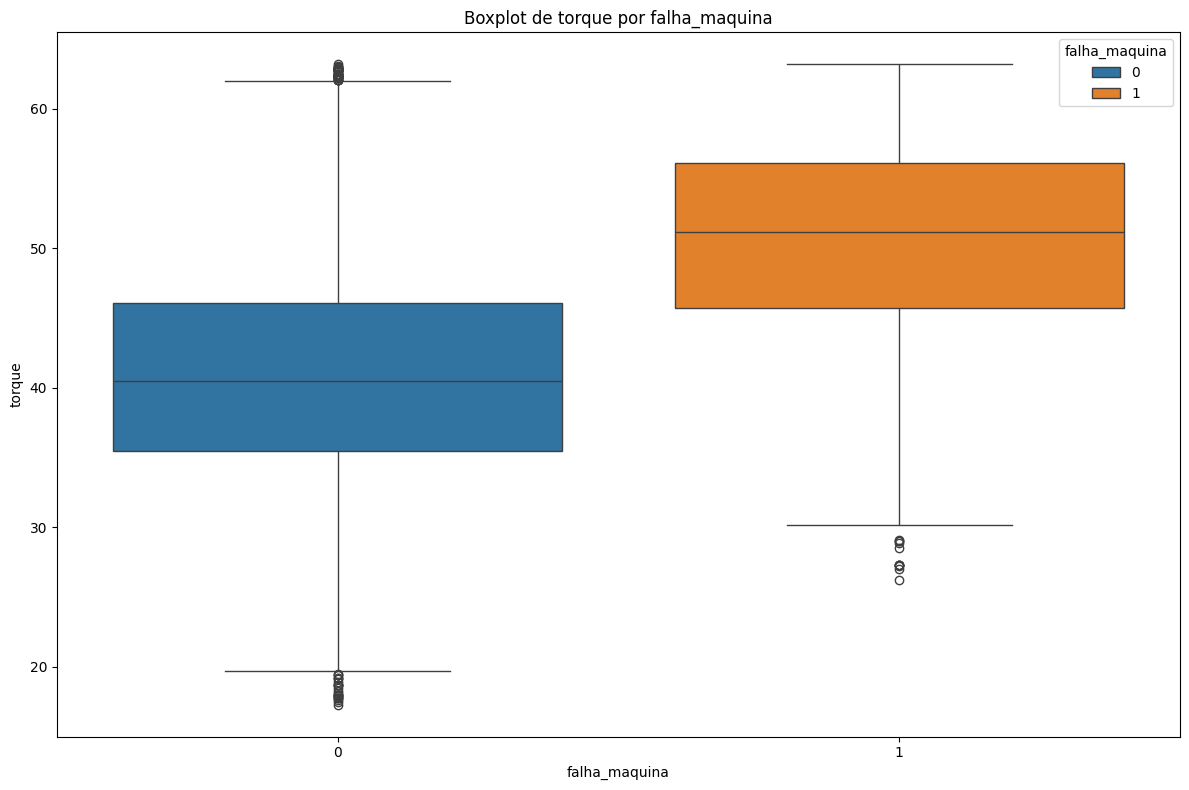

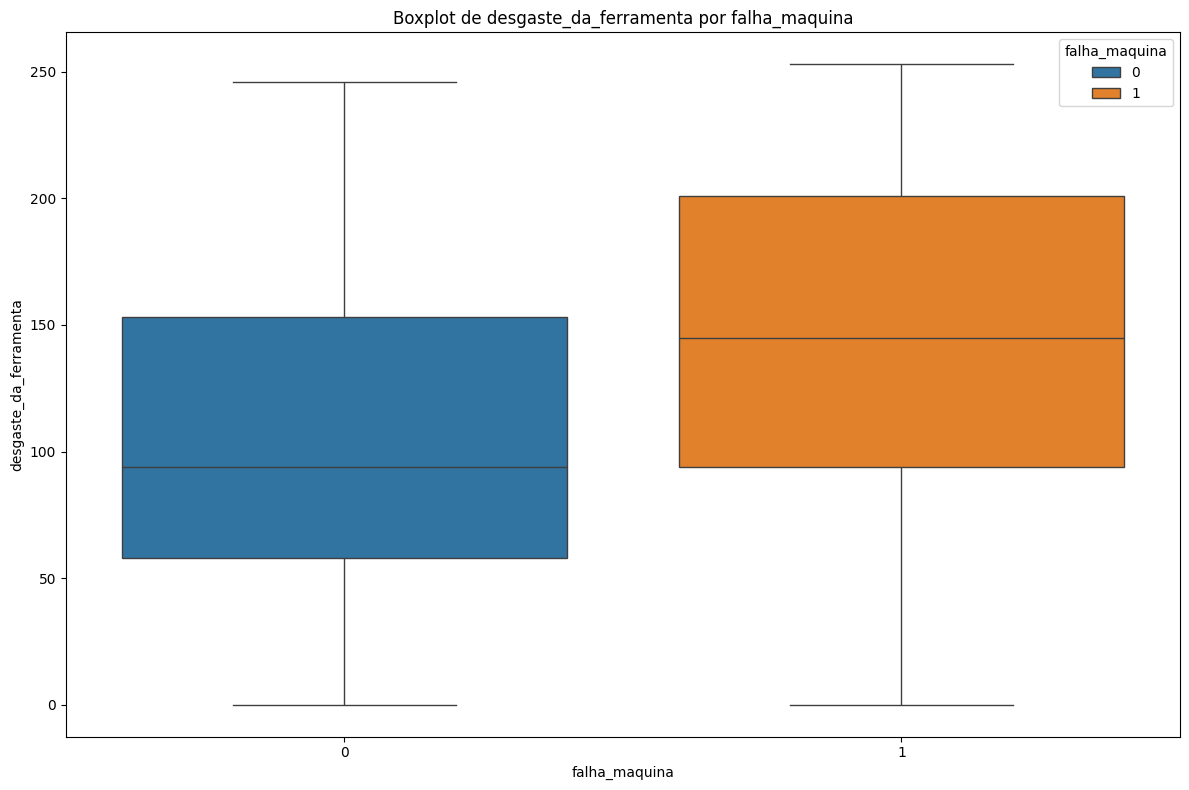

In [17]:
# Boxplots
for col in numeric_cols: plot_boxplots_category(df, col, 'falha_maquina')

### v) Testes Estatísticos

### a) Torque está associado à ocorrência de falha?

    - H0: A distribuição do `torque` é a mesma nos dois grupos (com e sem falha).
    - H1: A distribuição do `torque` é diferente dos dois grupos (com e sem falha).
    - Teste: Mann-Whitney U (teste não-paramétrico)

In [18]:
# Separar os grupos
grupo_falha = df[df["falha_maquina"] == 1]["torque"]
grupo_normal = df[df["falha_maquina"] == 0]["torque"]

# Teste de Mann-Whitney U
p_torque = mannwhitneyu(grupo_falha, grupo_normal, alternative='two-sided').pvalue

print(f"P-Value: {p_torque:.2e}")

if p_torque < 0.05:
    print("`P-Value` < 0.05: Resultado: Rejeitamos H0. Há evidência de que o torque difere entre máquinas com e sem falha.")
else:
    print("`P-Value` > 0.05: Resultado: Não rejeitamos H0. Não há evidência suficiente de diferença no torque.")


P-Value: 6.91e-119
`P-Value` < 0.05: Resultado: Rejeitamos H0. Há evidência de que o torque difere entre máquinas com e sem falha.


### b) A velocidade de rotação tem distribuição diferente entre máquinas com e sem falha?
    - H0: A distribuição de `velocidade_rotacional` é a mesma nos dois grupos (com e sem falha).
    - H1: A distribuição de `velocidade_rotacional` é diferente entre os dois grupos (com e sem falha).
    - Teste: Mann-Whitney U (teste não-paramétrico)

In [19]:
# Separar os grupos
grupo_falha_rpm = df[df["falha_maquina"] == 1]["velocidade_rotacional"]
grupo_normal_rpm = df[df["falha_maquina"] == 0]["velocidade_rotacional"]

# Teste de Mann-Whitney U
p_rpm = mannwhitneyu(grupo_falha_rpm, grupo_normal_rpm, alternative='two-sided').pvalue
print(f"P-Value: {p_rpm:.2e}")

if p_rpm < 0.05:
    print("`P-Value` < 0.05: Resultado: Rejeitamos H0. Há evidência de que a rotação difere entre os grupos.")
else:
    print("`P-Value` > 0.05: Resultado: Não rejeitamos H0. Não há evidência de diferença significativa na rotação.")


P-Value: 2.54e-108
`P-Value` < 0.05: Resultado: Rejeitamos H0. Há evidência de que a rotação difere entre os grupos.


### c) Máquinas com falha operam com maior temperatura de processo?

    - H0: A média da `temperatura_processo` é igual entre os grupos (com e sem falha).
    - H1: A média da `temperatura_processo` é diferente entre os grupos (com e sem falha).
    - Teste: t-Student (assumindo variâncias diferentes)

In [20]:
# Separar os grupos
df_temp_falha = df[df["falha_maquina"] == 1]["temperatura_processo"]
df_temp_normal = df[df["falha_maquina"] == 0]["temperatura_processo"]

# Teste t-Student (assumindo variâncias diferentes)
p_temp = ttest_ind(df_temp_falha, df_temp_normal, equal_var=False).pvalue

print(f"P-Value: {p_temp:.2e}")

if p_temp < 0.05:
    print("`P-Value` < 0.05: Resultado: Rejeitamos H0. Máquinas com falha operam com temperatura de processo diferente.")
else:
    print("`P-Value` > 0.05: Resultado: Não rejeitamos H0. Não há diferença significativa nas médias de temperatura.")


P-Value: 3.88e-11
`P-Value` < 0.05: Resultado: Rejeitamos H0. Máquinas com falha operam com temperatura de processo diferente.


**Insights:**
- **1.Torque está associado à ocorrência de falha?**
    - Decisão: Rejeitamos H0 com alta significância.
    - Conclusão: O torque tem comportamento significativamente diferente em situações de falha — é uma variável importante para detecção.

- **2.A velocidade de rotação tem distribuição diferente entre máquinas com e sem falha?**+
    - Decisão: Rejeitamos H0 com alta significância.
    - Conclusão:A velocidade de rotação comportamento significativamente diferente em situações de falha — é uma variável importante para detecção.

- **3.Máquinas com falha operam com maior temperatura de processo?**
    - Decisão: Rejeitamos H0 com alta significância.
    - Conclusão: Máquinas que apresentaram falha operam com temperaturas de processo significativamente maiores.

---

## 3) Feature Engineering

### i) Cria novas features

In [21]:
# Gradiente térmico (diferença entre processo e ambiente)
df['gradiente_termico'] = df['temperatura_processo'] - df['temperatura_ar']

# Potência mecânica estimada (W): P = τ * ω  (ω em rad/s)
df['potencia_maquina'] = (df['torque'] * df['velocidade_rotacional']) * 2*np.pi / 60.0

# Eficiência térmica ( Potencia / Gradiente Térmico) - Unidade: W/K
# relevante para FDC (quanto maior a energia dissipada em relação ao gradiente, maior risco de sobreaquecimento).
mask_pos = df['gradiente_termico'] > 0  # Evitar divisão por zero
df['coef_transferencia_calor'] = np.where(mask_pos,df['potencia_maquina'] / (df['gradiente_termico']),np.nan)

# Eficiência térmica ( 1 - (Gradiente Térmico / Temperatura Processo)) - Unidade: %
df['eficiencia_termica'] = 1 - (df['gradiente_termico'] / df['temperatura_processo'].replace(0, np.nan))

# Carga Mecânica Especifica ( Torque / Velocidade Rotacional) - Unidade: Nm/rad/s
# indicativo de FTE (tensão excessiva nos componentes mecânicos).
df['carga_mecanica_especifica'] = df['torque'] / (df['velocidade_rotacional'])

# Índice de Severidade
# pode indicar situações críticas onde calor + desgaste se sobrepõem.
# Desgaste por potencia = df['desgaste_da_ferramenta'] / (df['potencia_maquina'])
df['indice_severidade'] = (df['desgaste_da_ferramenta'] / (df['potencia_maquina'])) * df['gradiente_termico'].clip(lower=0)


In [22]:
# Reorganizar as colunas
cols_to_reorder = [
'tipo',
'temperatura_ar',
'temperatura_processo',
'gradiente_termico',
'coef_transferencia_calor',
'eficiencia_termica',
'velocidade_rotacional',
'torque',
'potencia_maquina',
'carga_mecanica_especifica',
'indice_severidade',
'desgaste_da_ferramenta',
'falha_maquina',
'tipo_falha',
'Desgaste da Ferramenta(FDF)',
'Dissipacao de Calor(FDC)',
'Falha de Potencia(FP)',
'Tensao Excessiva(FTE)',
'Falha Aleatoria(FA)',
]

# Reorganizar as colunas
df = df[cols_to_reorder]

# Selva os dados
df.to_csv('../data/processed/data_cleaned_features_engineering.csv', index=False)

### ii) Matriz de Correlação Númericas

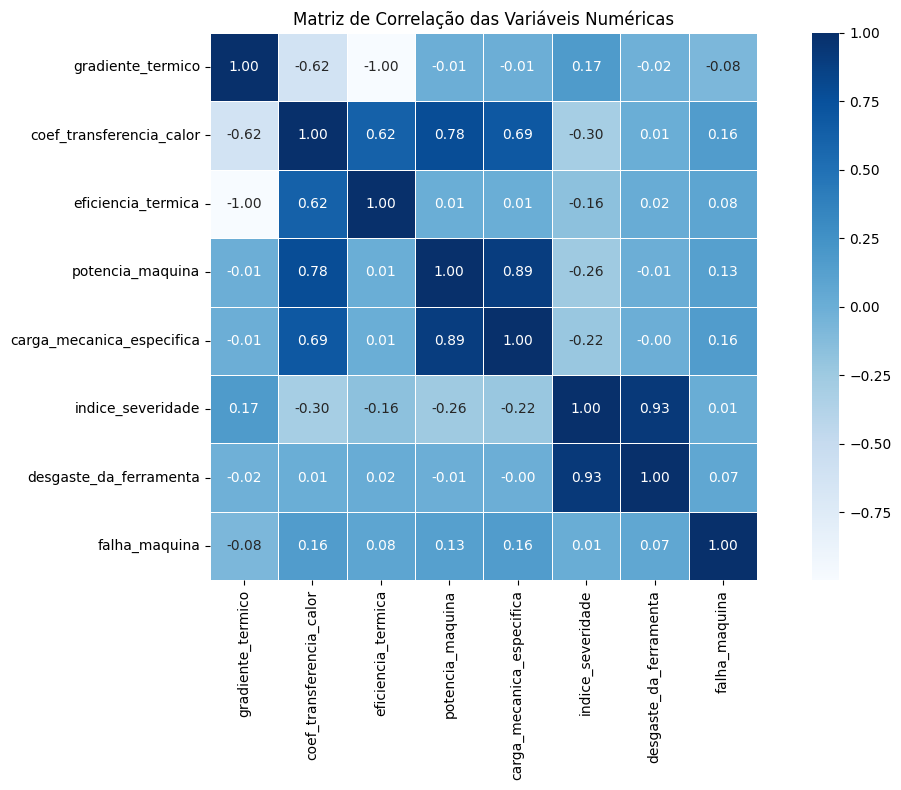

In [23]:
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Remover colunas binárias de falha
cols_to_drop = [
    'temperatura_ar',
    'temperatura_processo',
    'velocidade_rotacional',
    'torque',
    'tipo_Alta', 
    'tipo_Baixa', 
    'tipo_Media',
    'Desgaste da Ferramenta(FDF)', 
    'Dissipacao de Calor(FDC)', 
    'Falha de Potencia(FP)', 
    'Tensao Excessiva(FTE)', 
    'Falha Aleatoria(FA)'
    ]
numeric_cols = [col for col in numeric_cols if col not in cols_to_drop]

# Calcular a matriz de correlação
corr_df = df[numeric_cols].corr()

# Criar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, 
            annot=True,           # Mostrar os valores
            cmap='Blues',         # Esquema de cores
            fmt='.2f',           # Formato dos números
            linewidths=0.5,      # Largura das linhas
            square=True)         # Células quadradas

plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()              # Ajustar layout

# Salvar o gráfico
plt.savefig('../reports/figures/3_heatmap_correlation_new_features_', bbox_inches='tight', dpi=300)

# Mostrar o gráfico
plt.show()

**Insights:**
- `gradiente_termico` `vs eficiencia_termica` = -1 (correlação perfeita negativa)
    - Remover `gradiente_termico`e manter `eficiencia_termica` devido ser adimensional, normalizada e mais fácil de interpretar
- `desgaste_da_ferramenta` vs `indice_severidade` = 0.93 (muito alta)
    - Como o objetivo é robustez preditiva, recomendado remover `desgaste_da_ferramenta` e manter `indice_severidade` (que já é composto).
- `potencia_maquina` vs `carga_mecanica_especifica` = 0.89 (muito alta)
    - Ambas refletem esforço mecânico, mas com diferenças:
        - `potencia_maquina`: energia total consumida (torque × rotação) - Relacionado á Falhas de Potência (FP)
        - `carga_mecanica_especifica`: esforço relativo por rotação, mais sensível a sobrecarga local - Relacionado á Falhas de Tensão Excessiva (FTE)

### iii) Profile Report 

In [24]:
from ydata_profiling import ProfileReport


FILE_PATH = "../reports/profile_report_eda.html"

profile = ProfileReport(
    df,
    title="Profiling Report - Dados Limpos",
    explorative=False,                 # relatório mais compacto
    minimal=True,                      # desativa seções pesadas automaticamente
    correlations={
        "auto": {
            "pearson": True,
            "spearman": False,
            "kendall": False,
            "phi_k": False,
            "cramers": False
        }
    },
    interactions={"continuous": False},  # desativa matriz de interações
    samples={"head": 0, "tail": 0},     # não incluir amostras
    duplicates={"head": 0}              # não listar duplicatas
)

# Salva HTML estático
profile.to_file(FILE_PATH)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 558.86it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# visualizar inline
profile.to_notebook_iframe()
print(f"Relatório salvo em: {FILE_PATH}")

Relatório salvo em: ../reports/profile_report_eda.html
